In [ ]:
import os
import random
import librosa
import scipy
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from mlxtend.plotting import plot_decision_regions
from scipy.linalg import norm

#visualização
import seaborn
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset e Pré-Processamento**

In [ ]:
df_audio = pd.read_csv('/content/drive/My Drive/Audio Dataset/timeaudiofeatures1.csv')

In [ ]:
df_audio.shape

(500, 7)

In [ ]:
df_audio[95:105]

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,SOURCE,CLASS
95,0.376850,0.274201,70.0,Low,Slow,Synthesized,KICK
96,0.386825,0.267010,62.0,Low,Slow,Synthesized,KICK
97,0.372225,0.266065,60.0,Low,Slow,Synthesized,KICK
98,0.301200,0.220625,242.0,Low,Slow,Synthesized,KICK
99,0.549655,0.402491,41.0,Low,Slow,Synthesized,KICK
100,0.395515,0.179657,1412.0,Mid,Fast,Acoustic,SNARE
101,0.113857,0.073737,2447.0,Mid,Fast,Acoustic,SNARE
102,0.251307,0.143347,2184.0,Mid,Fast,Acoustic,SNARE
103,0.218819,0.146280,2334.0,Mid,Fast,Acoustic,SNARE
104,0.105065,0.050878,3789.0,Mid,Fast,Acoustic,SNARE


CLASSES:
- Kick = 0
- Snare = 1
- Clap = 2
- Tom = 3
- Closed Hihat = 4

TIPOS DE FEATURES:
1. *Valores Discretos* = **Zero-Crossing Rate**, Número de vezes que o sinal atravessa o valor zero por causa de uma oscilação

2. *Valores Contínuos* = **Root-Mean Square**, Valores médios de um sinal

3. *Valores Contínuos* = **Amplitude Envelope**, Valores máximos que representam os picos do sinal

4. *Valores Categóricos Ordinais* = **Low = 0 | Mid = 0.5 | High = 1**, Localização e faixa de alcance no domínio da frequência

5. *Valores Categóricos Ordinais* = **Fast = 0 | Slow = 1**, parâmetro que avalia o quão rápido o sinal decai  

6. *Valores Categóricos Nominais* = **Synthesized = 0 | Acoustic = 0.5 | Natural = 1**, Fonte sonora proveniente, se foi sintetizada, gerado de um instrumento ou uma fonte natural

**- CONVERTENDO CLASSES & VARIÁVEIS CATEGÓRICAS ORDINAIS**

In [ ]:
df_mod = df_audio

f = {'Low': 0, 'Mid': 1, 'High': 2}
t = {'Slow': 0, 'Fast': 1}
c = {'KICK': 0, 'SNARE': 1, 'CLAP': 2, 'TOM': 3, 'CLS HIHAT': 4}

df_mod['FREQ. RANGE'] = df_mod['FREQ. RANGE'].map(f)
df_mod['TIME DECAY'] = df_mod['TIME DECAY'].map(t)
df_mod['CLASS'] = df_mod['CLASS'].map(c)

In [ ]:
df_mod[295:305]

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,SOURCE,CLASS
295,0.150441,0.054951,3165.0,1.0,1.0,Natural,2
296,0.341565,0.117422,4119.0,1.0,1.0,Natural,2
297,0.128695,0.046633,5639.0,1.0,1.0,Natural,2
298,0.230720,0.078490,3552.0,1.0,1.0,Natural,2
299,0.293053,0.093872,746.0,1.0,1.0,Natural,2
300,0.065784,0.043514,197.0,0.0,0.0,Acoustic,3
301,0.070583,0.040046,190.0,0.0,0.0,Acoustic,3
302,0.060259,0.032513,267.0,0.0,0.0,Acoustic,3
303,0.087752,0.057360,270.0,0.0,0.0,Acoustic,3
304,0.091063,0.057556,136.0,0.0,0.0,Acoustic,3


**- CONVERTENDO VARIÁVEIS CATEGÓRICAS NOMINAIS (One-Hot Encoding)**

In [ ]:
pd.get_dummies(df_mod)

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,CLASS,SOURCE_Acoustic,SOURCE_Natural,SOURCE_Synthesized
0,0.504545,0.367265,154.0,0.0,0.0,0,0,0,1
1,0.277817,0.205872,1783.0,0.0,0.0,0,0,0,1
2,0.372127,0.272040,35.0,0.0,0.0,0,0,0,1
3,0.415194,0.325032,436.0,0.0,0.0,0,0,0,1
4,0.241500,0.182390,66.0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
495,0.091672,0.041861,3809.0,2.0,1.0,4,1,0,0
496,0.459318,0.166887,1990.0,2.0,1.0,4,1,0,0
497,0.195508,0.073991,3066.0,2.0,1.0,4,1,0,0
498,0.429237,0.184882,604.0,2.0,1.0,4,1,0,0


Eliminando uma das colunas para evitar redundância

In [ ]:
df_mod2 = pd.get_dummies(df_mod, drop_first=True)

In [ ]:
df_mod2

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,CLASS,SOURCE_Natural,SOURCE_Synthesized
0,0.504545,0.367265,154.0,0.0,0.0,0,0,1
1,0.277817,0.205872,1783.0,0.0,0.0,0,0,1
2,0.372127,0.272040,35.0,0.0,0.0,0,0,1
3,0.415194,0.325032,436.0,0.0,0.0,0,0,1
4,0.241500,0.182390,66.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...
495,0.091672,0.041861,3809.0,2.0,1.0,4,0,0
496,0.459318,0.166887,1990.0,2.0,1.0,4,0,0
497,0.195508,0.073991,3066.0,2.0,1.0,4,0,0
498,0.429237,0.184882,604.0,2.0,1.0,4,0,0


Colocando a coluna das labels por último 

In [ ]:
df_mod2.columns


Index(['AMP', 'RMS', 'ZCR', 'FREQ. RANGE', 'TIME DECAY', 'CLASS',
       'SOURCE_Natural', 'SOURCE_Synthesized'],
      dtype='object')

In [ ]:
new_colums = ['AMP', 'RMS', 'ZCR', 'FREQ. RANGE', 'TIME DECAY','SOURCE_Natural', 'SOURCE_Synthesized', 'CLASS']

In [ ]:
df_mod2 = df_mod2[new_colums]

In [ ]:
df_mod2

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,SOURCE_Natural,SOURCE_Synthesized,CLASS
0,0.504545,0.367265,154.0,0.0,0.0,0,1,0
1,0.277817,0.205872,1783.0,0.0,0.0,0,1,0
2,0.372127,0.272040,35.0,0.0,0.0,0,1,0
3,0.415194,0.325032,436.0,0.0,0.0,0,1,0
4,0.241500,0.182390,66.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...
495,0.091672,0.041861,3809.0,2.0,1.0,0,0,4
496,0.459318,0.166887,1990.0,2.0,1.0,0,0,4
497,0.195508,0.073991,3066.0,2.0,1.0,0,0,4
498,0.429237,0.184882,604.0,2.0,1.0,0,0,4


**- LIDANDO COM DADOS FALTANTES**

In [ ]:
df_mod2[346:347]

,AMP,RMS,ZCR,FREQ. RANGE,TIME DECAY,SOURCE_Natural,SOURCE_Synthesized,CLASS
346,0.069103,0.040844,281.0,NaN,0.0,0,0,3


In [ ]:
#Eliminando linhas com valores faltantes
df_mod2 = df_mod2.dropna(axis=0)

In [ ]:
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#df_mod3 = df_mod2.values
#df_mod3 = imputer.fit_transform(df_mod2.values)
#df_mod3

# **KNN (k-Nearest Neighbor Model)**

Separando em array de Features (X) e array Classes (y), transformando de tabela para matriz

In [ ]:
X = df_mod2.iloc[:, 0:7].values
X[0:5]

array([[5.0454540e-01, 3.6726484e-01, 1.5400000e+02, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.7781650e-01, 2.0587227e-01, 1.7830000e+03, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [3.7212700e-01, 2.7204010e-01, 3.5000000e+01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [4.1519433e-01, 3.2503214e-01, 4.3600000e+02, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.4149981e-01, 1.8238968e-01, 6.6000000e+01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [ ]:
y = df_mod2['CLASS'].values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,

In [ ]:
audio_all =  pd.DataFrame(df_mod2)
audio_data = pd.DataFrame(X)
audio_labels = pd.DataFrame(y)
audio_data.to_csv('/content/drive/My Drive/Audio Dataset/audio_data.csv', index = False,header=["AMP", "RMS", "ZCR", "FREQ. RANGE", "TIME DECAY", "SOURCE_Natural","SOURCE_Synthesized"])
audio_labels.to_csv('/content/drive/My Drive/Audio Dataset/audio_labels.csv', index = False,header=["CLASS"])
audio_all.to_csv('/content/drive/My Drive/Audio Dataset/audio_all.csv', index = False)

Separando Base de Treino e Base de Teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True, random_state=123, stratify=y)
np.bincount(y_train)

array([39, 40, 39, 40, 40])

In [ ]:
print(X_train.size, X_test.size, y_train.size, y_test.size)

1386 2079 198 297


 Normalização das Features de Treino

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)
X_train_std

array([[ 0.50728331,  0.04817471,  0.92063648, ...,  0.81477945,
        -0.49526056, -0.49526056],
       [ 0.24908597,  0.48103803, -0.88519862, ..., -1.227326  ,
        -0.49526056,  2.01913919],
       [-0.65865848, -0.28568081, -0.77326669, ..., -1.227326  ,
        -0.49526056, -0.49526056],
       ...,
       [ 1.93750804,  1.9552365 , -0.91791718, ..., -1.227326  ,
        -0.49526056,  2.01913919],
       [-0.89364872, -0.63840813,  0.04584542, ...,  0.81477945,
        -0.49526056, -0.49526056],
       [-0.2807964 , -0.58649184,  0.92982064, ...,  0.81477945,
         2.01913919, -0.49526056]])

Visualizando os a Base de Treino Normalizada

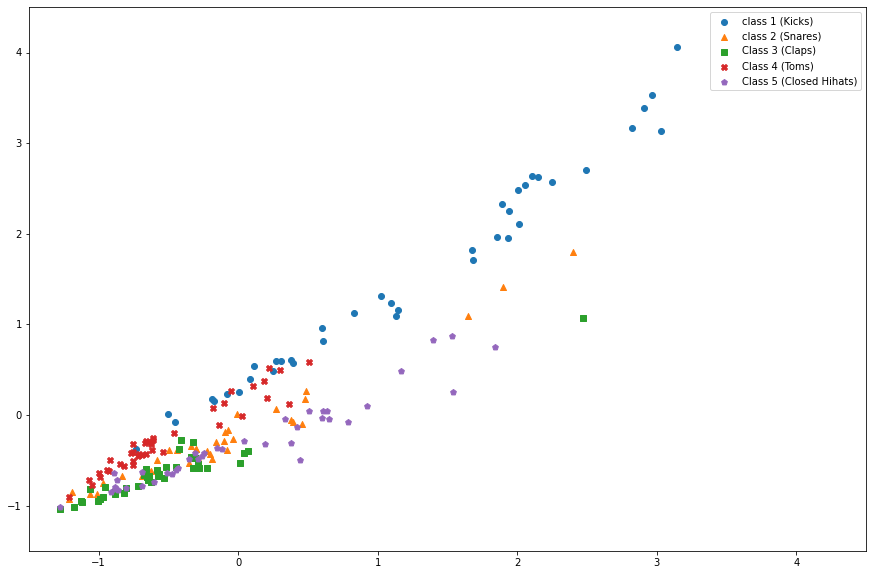

In [ ]:
plt.figure(figsize=(15, 10))

plt.scatter(X_train_std[y_train == 0, 0],
            X_train_std[y_train == 0, 1],
            marker='o',
            label='class 1 (Kicks)')

plt.scatter(X_train_std[y_train == 1, 0],
            X_train_std[y_train == 1, 1],
            marker='^',
            label='class 2 (Snares)')

plt.scatter(X_train_std[y_train == 2, 0],
            X_train_std[y_train == 2, 1],
            marker='s',
            label='Class 3 (Claps)')
plt.scatter(X_train_std[y_train == 3, 0],
            X_train_std[y_train == 3, 1],
            marker='X',
            label='Class 4 (Toms)')
plt.scatter(X_train_std[y_train == 4, 0],
            X_train_std[y_train == 4, 1],
            marker='p',
            label='Class 5 (Closed Hihats)')

plt.xlim((-1.5, 4.5))
plt.ylim((-1.5, 4.5))
plt.legend(loc='upper right')
plt.show()

Treinando o modelo

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Fazendo a avaliação

In [ ]:
y_pred = knn_model.predict(X_test_std)
print(y_pred)
print(y_test)

[4 2 1 3 3 4 4 3 2 4 2 0 4 4 2 3 1 4 1 2 3 3 3 3 3 2 1 4 1 4 3 2 1 2 1 3 2
 0 1 4 0 3 1 3 4 1 3 0 2 1 0 2 4 2 1 2 2 0 1 4 3 0 2 4 3 3 4 0 1 1 2 3 4 4
 2 4 0 1 3 0 3 4 0 3 2 0 2 2 3 2 2 1 2 0 4 3 4 4 1 2 1 0 0 1 0 1 2 4 0 0 2
 4 3 1 3 3 2 3 4 4 3 0 4 0 2 1 0 4 1 0 1 2 4 1 2 1 1 3 0 4 0 4 1 2 4 3 2 4
 1 1 0 3 3 3 1 2 4 2 4 3 3 2 3 1 0 0 4 3 2 3 0 4 3 2 3 0 4 0 4 1 1 2 3 4 1
 1 2 0 2 4 2 0 0 3 4 1 1 4 4 2 2 2 1 4 0 3 2 0 0 0 1 0 3 0 2 0 4 0 0 1 1 0
 1 4 1 0 0 4 1 2 4 3 1 3 0 1 0 0 2 1 3 3 4 0 1 0 1 3 4 3 4 0 1 1 0 2 2 0 3
 0 4 0 2 3 3 2 2 1 4 3 4 3 1 2 3 4 1 0 2 2 2 1 0 4 0 3 1 3 0 2 3 4 0 1 2 4
 1]
[4 2 1 3 3 4 4 3 2 4 2 0 4 4 2 3 1 4 1 2 3 3 3 3 3 2 1 4 1 4 3 2 1 2 1 3 2
 0 1 4 0 3 1 3 4 1 3 0 2 1 0 2 4 2 1 2 2 0 1 4 3 0 2 4 3 3 4 0 1 1 2 3 4 4
 2 4 0 1 3 0 3 4 0 3 2 0 2 2 3 2 2 1 2 0 4 3 4 4 1 2 1 0 0 1 0 1 2 4 0 0 2
 4 3 1 3 3 2 3 4 4 3 0 4 0 2 1 0 4 1 0 1 2 4 1 2 1 1 3 0 4 0 4 1 2 4 3 2 4
 1 1 0 3 3 3 1 2 4 2 4 3 3 2 3 1 0 0 4 3 2 3 0 4 3 2 3 0 4 0 4 1 1 2 3 4 1
 1 2 0 2 4 2 0 0 3 4 

In [ ]:
accuracy_score(y_test, y_pred)

0.9966329966329966